# Process Cap Quotes

This notebook 
* converts Bloomberg cap quotes into Black flat vols.
* interpolates the vol curve
* interpolates the SOFR swap curve from BB quotes.
* calculates swap, discount, and forward curves

User picks a date, and among the historic dates loaded, it builds the curves for this particular date.

Pair this notebook with `build_data/Build Cap Quotes - Bloomberg`.

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ratecurves import *
from ficcvol import *

from datetime import datetime
import warnings

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

***

In [3]:
FILEIN = 'cap_quotes_2023-05-01'
freqcap = 4
# can adjust frequency for binomial tree later, but keep quarterly to properly get caps

### Select Date for Analysis

In [4]:
DATE = '2023-05-10'

### Export Curves to Excel

In [5]:
SAVEDATA = True
FILEOUT = f'../data/cap_curves_{DATE}.xlsx'

# SOFR Quotes

In [6]:
SHEET = 'sofr'
sofrdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
sofrdata.columns = sofrdata.loc['maturity'] 
sofrdata.drop(index=['maturity'],inplace=True)
sofrdata.index = pd.to_datetime(sofrdata.index)

sofrdata.columns.name ='maturity'

Bloomberg reports rates as percentages; convert to numbers.

In [7]:
sofrdata /= 100

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [8]:
sofrdata = sofrdata.T.drop_duplicates().T

## Get Curves

Need discount and forward curves.

Need to interpolate swap rates for quarterly frequency beyond $T=3$ (which is where Bloomberg moves from monthly to semiannual tenors.)

Many reasonable methods, try `cubicspline`.

In [9]:
sofrdata

maturity,0.251882,0.503765,0.755647,1.002053,1.253936,1.505818,1.757700,2.001369,2.253251,2.505133,...,3.000684,3.504449,4.000000,4.503765,5.002053,6.001369,7.000684,8.000000,9.002053,10.001369
date,,,,,,,,,,,,,,,,,,,,,
2023-05-01,0.051123,0.051210,0.050235,0.048886,0.046585,0.044565,0.042872,0.041453,0.040090,0.039060,...,0.037547,0.036345,0.035539,0.03484,0.034445,0.033842,0.033452,0.033230,0.033147,0.033112
2023-05-02,0.050566,0.050145,0.048915,0.047262,0.044925,0.042780,0.041010,0.039555,0.038195,0.037115,...,0.035598,0.034435,0.033618,0.03297,0.032590,0.032086,0.031800,0.031655,0.031653,0.031685
2023-05-03,0.050583,0.049855,0.048212,0.046205,0.043572,0.041264,0.039363,0.037885,0.036495,0.035410,...,0.033909,0.032765,0.032074,0.03151,0.031235,0.030877,0.030745,0.030716,0.030805,0.030933
2023-05-04,0.050505,0.049615,0.047750,0.045659,0.043000,0.040745,0.038925,0.037562,0.036275,0.035275,...,0.033925,0.032925,0.032236,0.03168,0.031480,0.031150,0.031000,0.030980,0.031060,0.031190
2023-05-05,0.050720,0.050104,0.048520,0.046620,0.044106,0.041885,0.040178,0.038810,0.037450,0.036450,...,0.035024,0.033885,0.033165,0.03258,0.032271,0.031876,0.031685,0.031620,0.031666,0.031760
2023-05-08,0.050849,0.050306,0.048686,0.046865,0.044274,0.042128,0.040433,0.039027,0.037738,0.036743,...,0.035336,0.034225,0.033493,0.03286,0.032621,0.032238,0.032064,0.032000,0.032066,0.032162


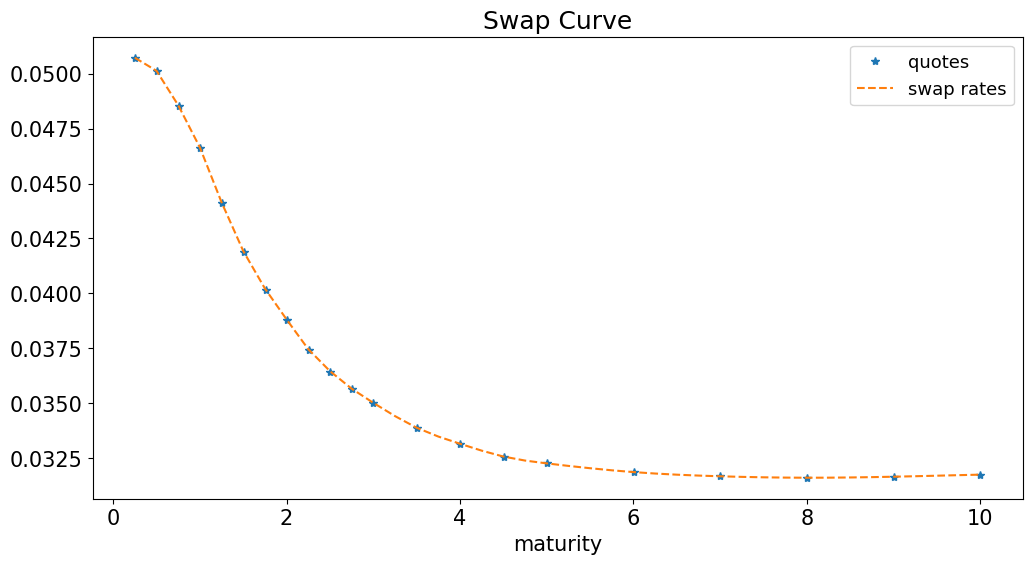

In [10]:
sofrcurves = interp_curves(sofrdata, dt = 1/freqcap, date=DATE, interp_method='cubicspline').rename(columns={'interp':'swap rates'})
sofrquotes = sofrdata.loc[DATE,:].rename('quotes')

### Plot the Curve
fig, ax = plt.subplots()
sofrquotes.plot.line(ax=ax, linestyle='None',marker='*')
sofrcurves['swap rates'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Swap Curve');

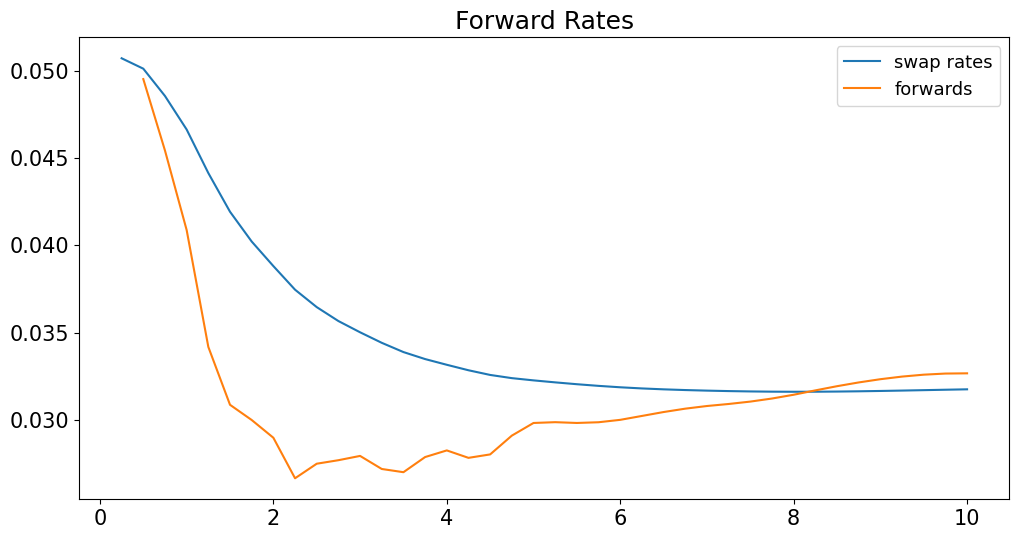

In [11]:
sofrcurves['discounts'] = ratecurve_to_discountcurve(sofrcurves['swap rates'],n_compound=freqcap)
sofrcurves['forwards'] = ratecurve_to_forwardcurve(sofrcurves['swap rates'],n_compound=freqcap)
sofrcurves[['swap rates','forwards']].plot(title='Forward Rates');

# Cap Quotes

In [12]:
SHEET = 'cap'
capdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
capdata.columns = capdata.loc['maturity'] 
capdata.drop(index=['maturity'],inplace=True)
capdata.index = pd.to_datetime(capdata.index)

Bloomberg reported years-to-maturity are precise.
Round these to nearest $dt$ for better column headers
For more precise work, would need to make use of the precise maturities, but for this purpose will make no difference.

In [13]:
capdata.columns = (freqcap * capdata.columns.values).round(0)/freqcap
capdata.columns.name ='maturity'

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [14]:
capdata = capdata.T.drop_duplicates().T

## Adjusting Normal Vol to Lognormal (Black) Vol

Cap quotes in Bloomberg are downloaded in
* normal vol
* terminal allows view of lognormal (Black) vol, but API seemingly restricts to normal.

The normal vols are reported in basis points.
* divide out by $100^2$

Converting between normal and lognormal vol is given by a simple formula for ATM options, (according to SABR, etc.)

$$\sigma_B = \frac{\sigma_N}{f}$$

where $f$ is the forward rate.

In [15]:
capquotes = capdata.loc[DATE,:].to_frame()
capquotes.columns = ['normal']
capquotes[DATE] = capquotes['normal'] / sofrcurves['forwards'] / 100**2

# Interpolate or Extrapolate

Interpolate/extrapolate just to get to quarterly frequency needed for forward vol extraction.

After extracting forward vol, can interpolate/extrapolate further for matching timegrid of binomial trees.

#### Interpolation
Need to interpolate cap rates for quarterly frequency as Bloomberg reports only at annual tenors.

Try `cubicspline`.

#### Extrapolation
Also need to extrapolate the short end of the curve, $t<1$.
* This can lead to negative values w/ cubic spline and others.
* Here, ad hoc set front to `FRONT_RATIO` the first quote and linearly extrapolate

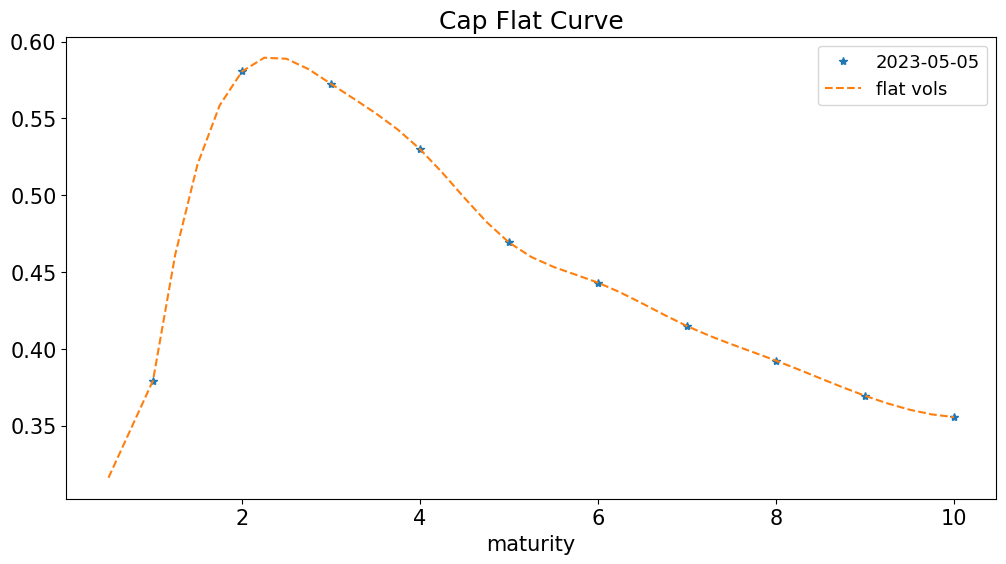

In [16]:
LIN_EXTRAP = True
FRONT_RATIO = .75

capcurves = interp_curves(capquotes[[DATE]].T,dt=1/freqcap, date=DATE,interp_method='cubicspline').rename(columns={'interp':'flat vols'})

if LIN_EXTRAP:
    fix_short = capcurves.loc[:1,'flat vols']
    fix_short.iloc[:-1] = np.nan
    fix_short.iloc[0] = capcurves.loc[1,'flat vols'] * FRONT_RATIO
    capcurves.loc[:1,'flat vols'] = fix_short.interpolate(limit_direction='both', fill_value = 'extrapolate')

# drop extrapolated value at first period as there is no caplet for the first period.
capcurves['flat vols'].iloc[0] = np.nan

### Plot the Curve
fig, ax = plt.subplots()
capquotes[[DATE]].rename(columns={'black':'quotes'}).plot.line(ax=ax, linestyle='None',marker='*')
capcurves['flat vols'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Cap Flat Curve');

In [17]:
capcurves = flat_to_forward_vol_rev(capcurves['flat vols'],sofrcurves['swap rates'],sofrcurves['forwards'],sofrcurves['discounts'],freq=4)

### Save Data

In [18]:
outdata = pd.concat([sofrcurves.drop(columns=['quotes']), capcurves.drop(columns=['cap prices'])],axis=1)
outdata.index.name = 'tenor'

if SAVEDATA:    
    with pd.ExcelWriter(FILEOUT) as writer:  
        outdata.to_excel(writer, sheet_name= f'rate curves {DATE}', index=True)